In [1]:
import math
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from main import nmf_son, nmf_son_acc
from sklearn.decomposition import NMF
from mpl_toolkits.axes_grid1 import make_axes_locatable


np.random.seed(42)
np.set_printoptions(precision=3)

In [2]:
def normalized_similarity(W_ins):
    r = W_ins.shape[1]
    res = np.ones(shape=(r, r)) * -1
    for i in range(r):
        for j in range(r):
            res[i, j] = np.linalg.norm(W_ins[:, i] - W_ins[:, j])
        res[i, :] = res[i, :] / sum(res[i, :])
    return res

def plot_scores(fscores, gscores, lambda_vals):
    def plot_ax(ax, f, g, total):
        ax.plot(total, color='black', linewidth=3, label='total')
        ax.plot(f, label='f')
        ax.plot(g, label='g')
        ax.legend()

    total_score = fscores + lambda_vals * gscores
    fig, axs = plt.subplots(1, 2, figsize=(20, 6))

    axs[0].set_yscale('log')
    plot_ax(axs[0], fscores, gscores, total_score)
    axs[0].set_title('log scale', fontsize=16)

    axs[1].set_yscale('log')
    plot_ax(axs[1], fscores - fscores[-1], gscores - gscores[-1], total_score - total_score[-1])
    axs[1].set_title('log(score - score*)', fontsize=16)

def plot_matrices(W, H, img_size, comparison_idxs, share_y=False):
    fig, axs = plt.subplots(2, len(comparison_idxs), figsize=(20, 10), sharey='row' if share_y else False)

    for i, idx in enumerate(comparison_idxs):
        axs[0, i].plot(W[:, idx] / np.dot(W[:, idx], W[:, idx]))
        axs[0, i].set_title(f'W({idx+1})')

        h_idx_3d = H[idx, :].reshape(img_size, order='F')
        axs[1, i].plot(h_idx_3d)
        axs[1, i].set_title(f'H({idx+1})')

def plot_images(H, img_size, comparison_idxs):
    fig, axs = plt.subplots(1, len(comparison_idxs), figsize=(20, 10))

    for i, idx in enumerate(comparison_idxs):
        h_idx_3d = H[idx, :].reshape(img_size, order='F')

        axs[i].imshow(h_idx_3d)
        img = axs[i].imshow(h_idx_3d, cmap='gray')
        divider = make_axes_locatable(axs[i])

        cax = divider.append_axes('right', size='5%', pad=0.1)
        fig.colorbar(img, cax=cax, orientation='vertical')
        axs[i].set_title(f'H({idx+1})')

def load_results(filepath):
    data = np.load(filepath)
    return data['Wb'], data['Hb'], data['Wl'], data['Hl'], data['fscores'], data['gscores'], data['lambda_vals']

In [3]:
mat = scipy.io.loadmat('jasper/jasper.mat')
X3d = mat['X']
X = X3d.reshape(100 * 100, -1, order='F').T
X3d_new = X.reshape(-1, 100, 100, order='F')

In [4]:
(X < 0).sum()

16017

In [5]:
X[X < 0] = 0

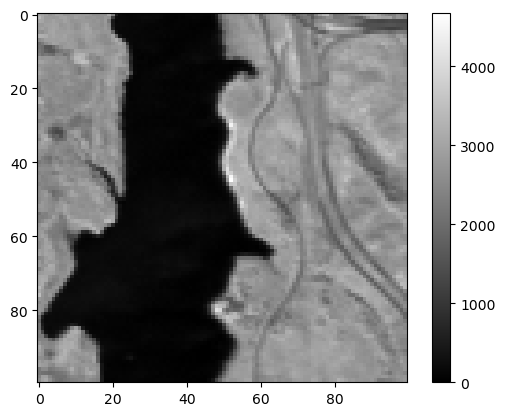

In [6]:
wavelength = 80
plt.imshow(X3d_new[wavelength, :, :], cmap='gray')
plt.colorbar()

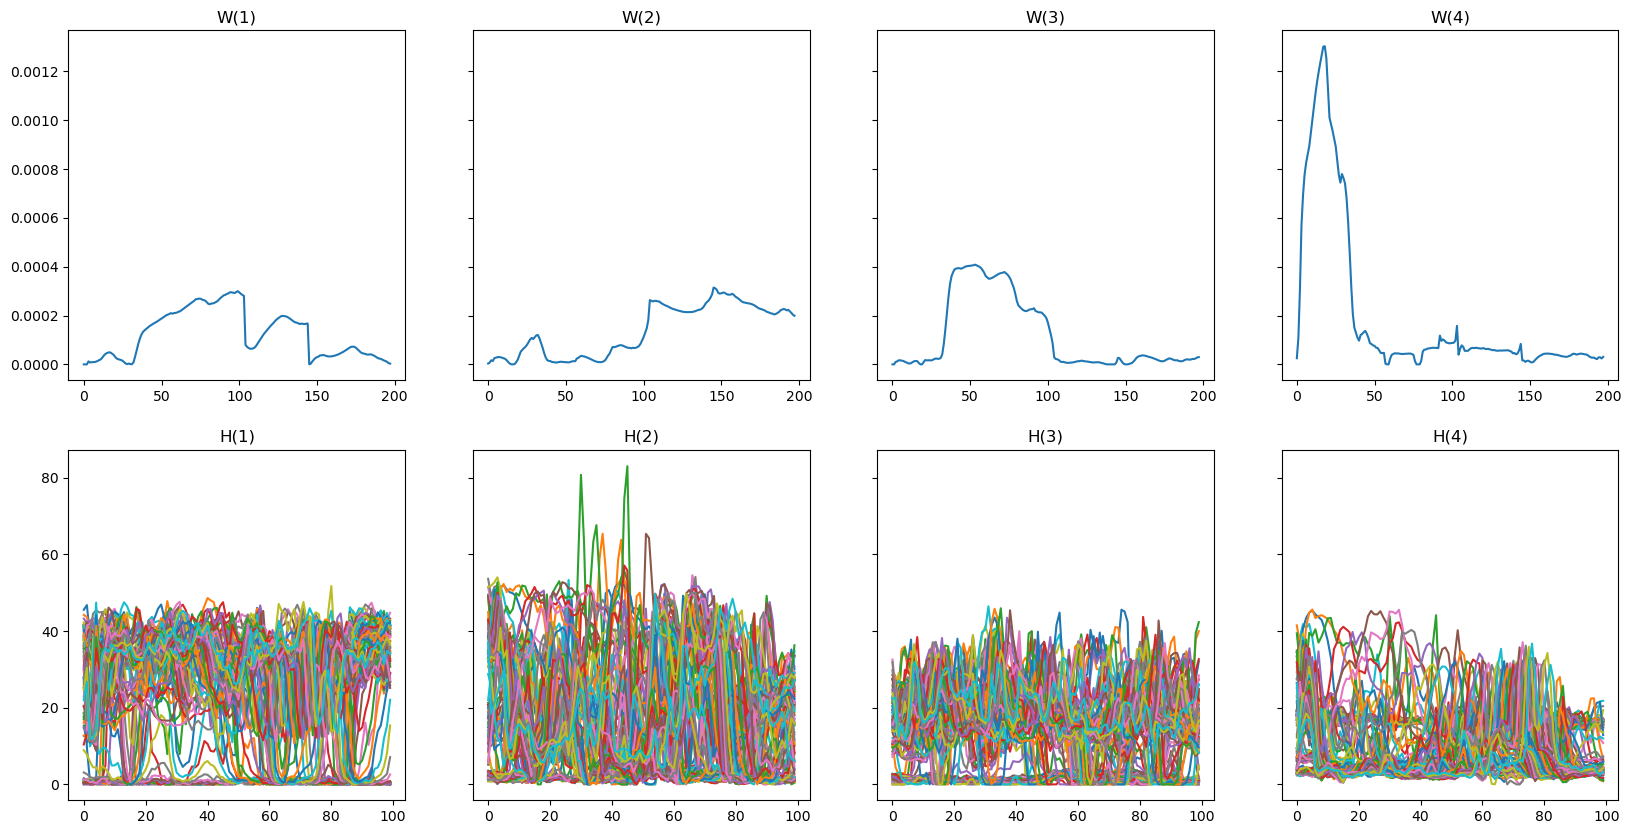

In [7]:
model = NMF(n_components=4, init='random', random_state=42, max_iter=5000)
vanillaW = model.fit_transform(X)
vanillaH = model.components_

img_size = (100, 100)
plot_matrices(vanillaW, vanillaH, img_size, range(4), share_y=True)

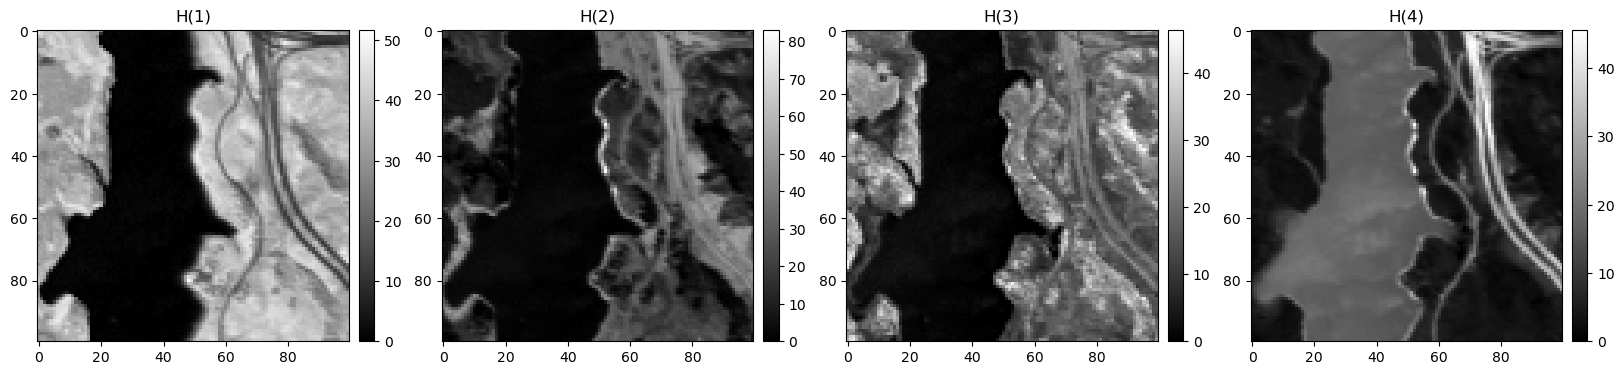

In [8]:
plot_images(vanillaH, img_size, range(4))

In [9]:
m, n = X.shape
rank = 6

ini_W = np.random.rand(m, rank)
ini_H = np.random.rand(rank, n)

In [10]:
Wb, Hb, Wl, Hl, fscores, gscores, lvals = nmf_son_acc(X, ini_W.copy(), ini_H.copy(), _lambda=2, itermax=100, verbose=True)

Iteration: 1, f=391547.68369585235, g=2706.1240596533553,  total=137185181.4828945
Iteration: 2, f=256532.67025917975, g=3130.722266540011,  total=1162497.825393859
Iteration: 3, f=155182.31116985052, g=3807.0188133580377,  total=779079.68613375
Iteration: 4, f=116774.18576268145, g=4211.567236926051,  total=460119.34349092655
Iteration: 5, f=103574.17891412435, g=4421.353280013692,  total=348756.03174836666
Iteration: 6, f=97027.2983666537, g=4555.422419550381,  total=310457.0366527847
Iteration: 7, f=92997.20959716453, g=4651.03593029313,  total=291124.8075937162
Iteration: 8, f=90364.67185468228, g=4721.905314380789,  total=279193.1499833213
Iteration: 9, f=88559.643061452, g=4777.344030752624,  total=271410.88506374863
Iteration: 10, f=87253.51402799223, g=4823.213560820482,  total=266073.40583642235
Iteration: 11, f=86254.03390649949, g=4862.601518271377,  total=262186.1440803038
Iteration: 12, f=85449.99052370807, g=4897.349017930327,  total=259190.7779015274
Iteration: 13, f=847

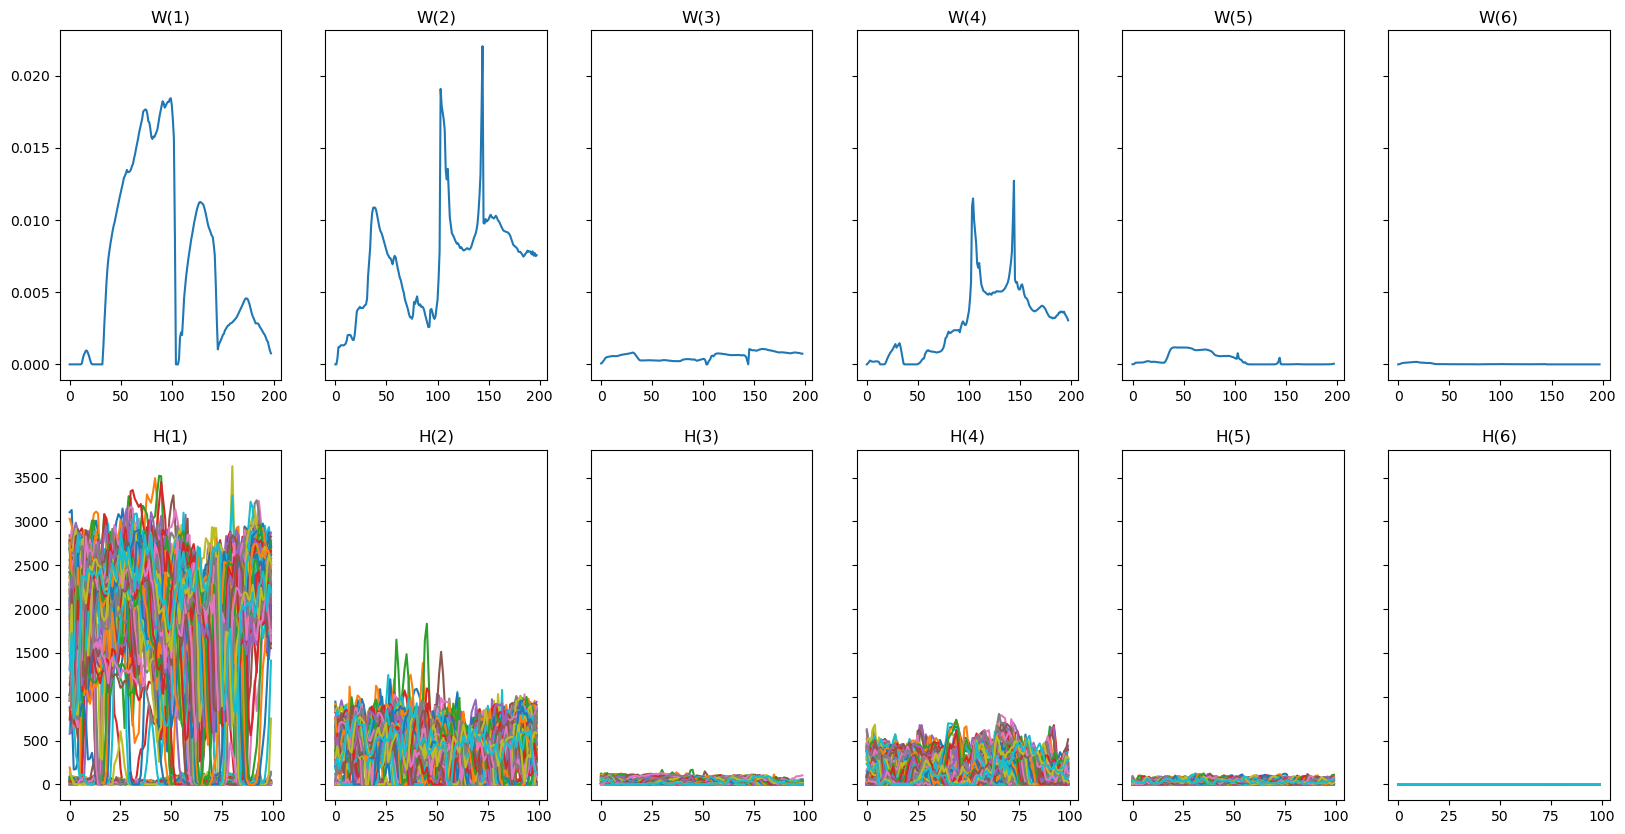

In [11]:
plot_matrices(Wl, Hl, img_size, range(rank), share_y=True)

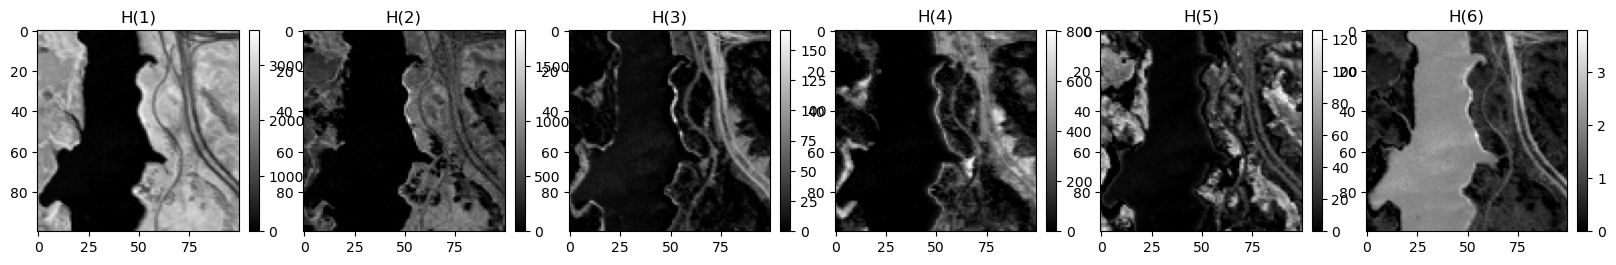

In [12]:
plot_images(Hl, img_size, range(rank))